In [1]:
#! /usr/bin/env python3

from pymatgen.io.vasp import Structure, Lattice, Xdatcar
from polyhedral_analysis.polyhedra_recipe import create_matching_site_generator
from vasppy.rdf import RadialDistributionFunction

import yaml
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib notebook

import sys
sys.path.insert(0, "../../scripts/")
from utils import flatten_list, get_structures, indices_by_species

In [2]:
with open('../md_runs.yaml', 'r') as f:
    md_runs = yaml.load(f)
print(md_runs)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


In [3]:
# x_spec = { 'Li6PS5I': 'I',
#            'Li6PS5Cl': 'Cl' }
data_dir = '../../data'

rdf_data = {}
for system in md_runs:
    rdf_data[system] = {}
    for disorder, runs in md_runs[system].items():
        rdf_data[system][disorder] = {}
        xdatcar_filenames = [ f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs ]
        xdatcars = ( Xdatcar( f ) for f in xdatcar_filenames )
        structures = flatten_list( [ x.structures for x in xdatcars ] )
        li_indices = indices_by_species( structures[0], 'Li' )
        print(f'{system} {disorder} Li-Li inherent')
        rdf_data[system][disorder]['Li-Li'] = RadialDistributionFunction( structures, li_indices, 
                                                                          li_indices, r_max=5.0 )
inherent_rdf_data = rdf_data


rdf_data = {}
for system in md_runs:
    rdf_data[system] = {}
    for disorder, runs in md_runs[system].items():
        rdf_data[system][disorder] = {}
        xdatcar_filenames = [ f'{data_dir}/{system}/{disorder}/run{i}/actual_XDATCAR.gz' for i in runs ]
        xdatcars = ( Xdatcar( f ) for f in xdatcar_filenames )
        structures = flatten_list( [ x.structures for x in xdatcars ] )
        li_indices = indices_by_species( structures[0], 'Li' )
        print(f'{system} {disorder} Li-Li actual')
        rdf_data[system][disorder]['Li-Li'] = RadialDistributionFunction( structures, li_indices, 
                                                                          li_indices, r_max=5.0 )
actual_rdf_data = rdf_data

Li6PS5I 0p Li-Li inherent
Li6PS5I 50p Li-Li inherent
Li6PS5I 100p Li-Li inherent
Li6PS5Cl 0p Li-Li inherent
Li6PS5Cl 50p Li-Li inherent
Li6PS5Cl 100p Li-Li inherent
Li6PS5I 0p Li-Li actual
Li6PS5I 50p Li-Li actual
Li6PS5I 100p Li-Li actual
Li6PS5Cl 0p Li-Li actual
Li6PS5Cl 50p Li-Li actual
Li6PS5Cl 100p Li-Li actual


/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


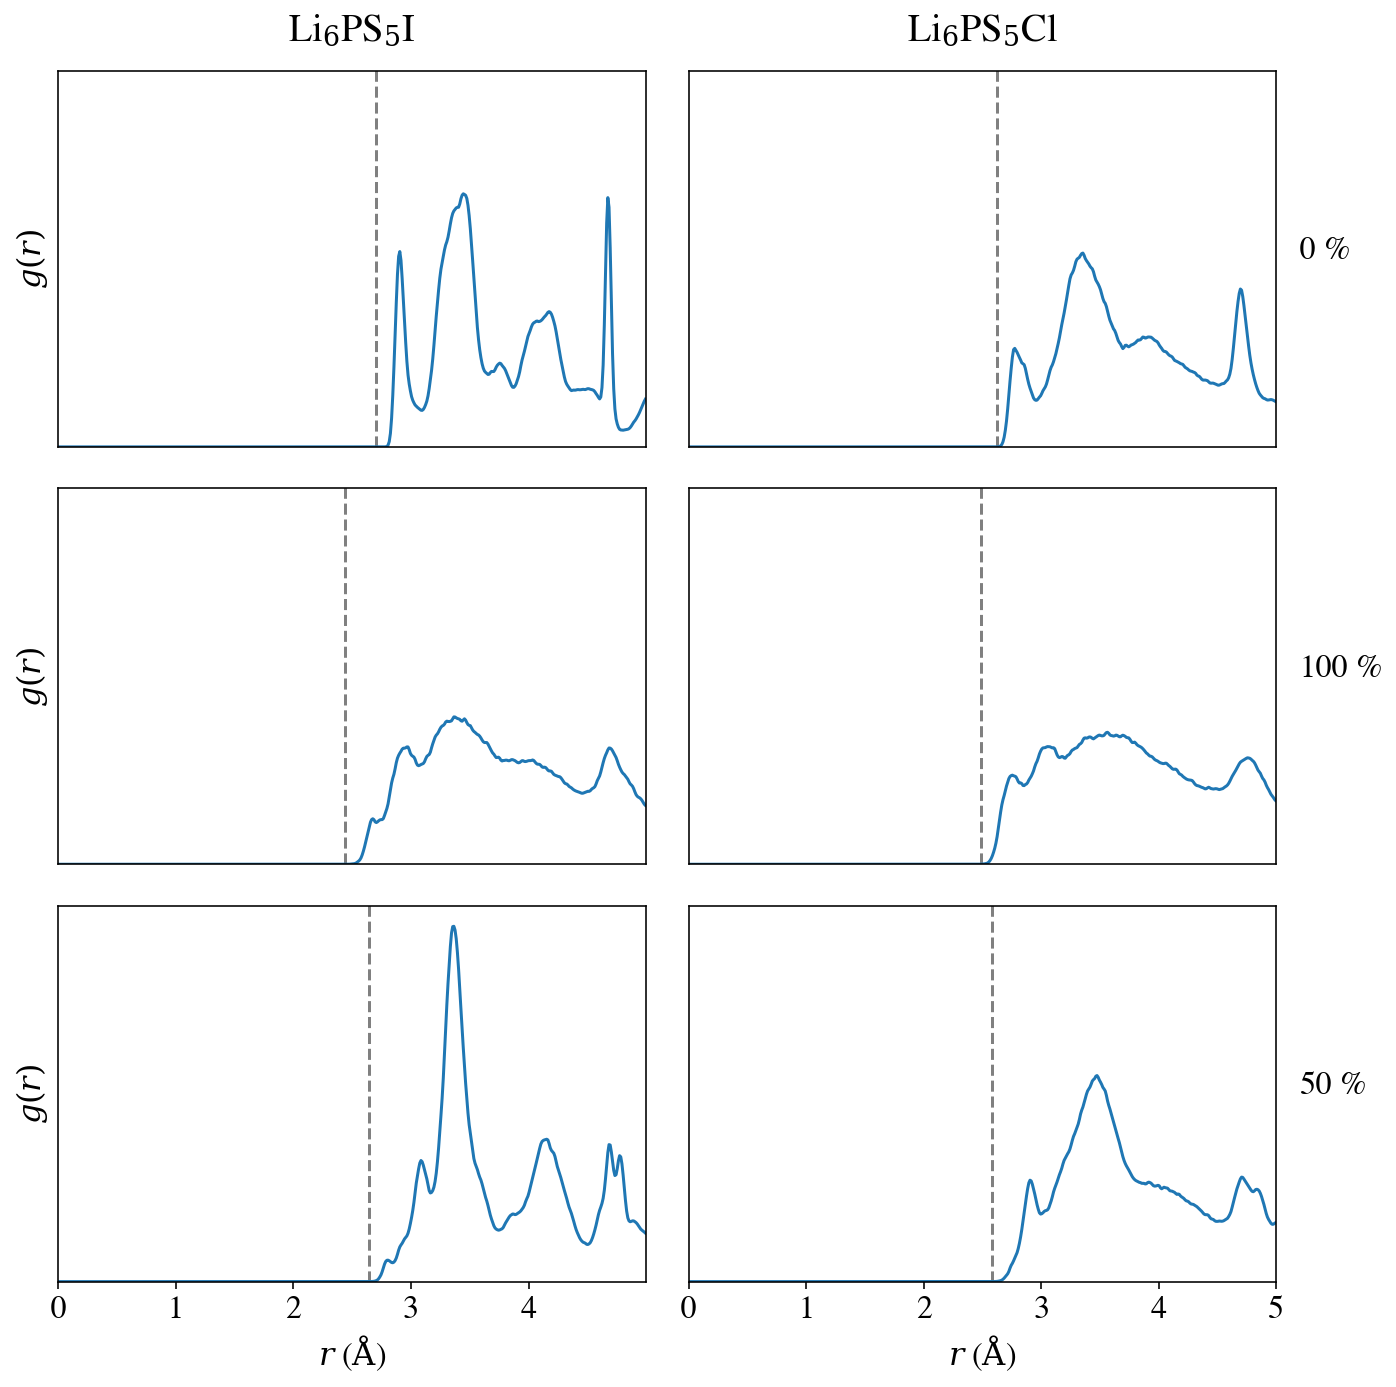

In [4]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Minion Pro']
rcParams['font.size'] = 16
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['mathtext.fontset'] = 'dejavuserif'

def plot_rdf(rdf, axes, sigma, label=None):
    axes.plot(rdf.r, rdf.smeared_rdf(sigma=sigma), label=label)
    onset = rdf.r[np.where(rdf.rdf>0)[0][0]]
    axes.vlines(onset, 0.0, 5.0, linestyle='--', color='grey')
    
def plot_summed_rdfs(rdfs, axes, sigma, label=None):
    axes.plot(rdfs[0].r, np.mean( [ rdf.smeared_rdf(sigma=sigma) for rdf in rdfs ], axis=0 ), label=label )
              
sigma = 0.01
fig, ax = plt.subplots(3,2,figsize=(10,10))

plot_rdf(inherent_rdf_data['Li6PS5I']['0p']['Li-Li'], axes=ax[0,0], sigma=sigma)
plot_rdf(inherent_rdf_data['Li6PS5I']['50p']['Li-Li'], axes=ax[1,0], sigma=sigma)
plot_rdf(inherent_rdf_data['Li6PS5I']['100p']['Li-Li'], axes=ax[2,0], sigma=sigma)

plot_rdf(inherent_rdf_data['Li6PS5Cl']['0p']['Li-Li'], axes=ax[0,1], sigma=sigma)
plot_rdf(inherent_rdf_data['Li6PS5Cl']['50p']['Li-Li'], axes=ax[1,1], sigma=sigma)
plot_rdf(inherent_rdf_data['Li6PS5Cl']['100p']['Li-Li'], axes=ax[2,1], sigma=sigma)

y_max = 4.5
for i in range(3):
    for j in range(2):
        ax[i,j].set_ylim([0,y_max])
        ax[i,j].set_xlim([0,5])
        ax[i,j].set_yticks([])
        
for i in range(2):
    for j in range(2):
        ax[i,j].get_xaxis().set_visible(False)
        
for i in range(3):
        ax[i,1].get_yaxis().set_visible(False)

xlabel = r'$r$ ($\mathrm{\AA}$)'
ylabel = r'$g(r)$'
ax[2,0].set_xticks(range(5))
ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15)
ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15)
ax[2,0].set(xlabel=xlabel, ylabel=ylabel)
ax[1,0].set(ylabel=ylabel)
ax[0,0].set(ylabel=ylabel)
ax[2,1].set(xlabel=xlabel)

ax[0,1].text(5.2,y_max/2,'0 %')
ax[1,1].text(5.2,y_max/2,'100 %')
ax[2,1].text(5.2,y_max/2,'50 %')
    
fig.tight_layout()    
# fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('../../figures/Li-Li-rdf.pdf')
fig.show()

In [5]:
data = inherent_rdf_data['Li6PS5I']['0p']['Li-Li']
data.r[np.where(data.rdf>0)[0][0]]

2.705